In [2]:
import pandas as pd
from torch.utils import data
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
import torch.utils.data as Data
import torchvision.models as models
import numpy as np
import os
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import time
import copy
import matplotlib.pyplot as plt
from ResNet import *

In [2]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)

In [3]:
class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode, transform=None):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        path = os.path.join(os.getcwd(), root)
        self.root = path
        self.img_name, self.label = getData(mode)
        self.mode = mode
        self.transform = transform
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        img_path = self.root + "/" + self.img_name[index] + ".jpeg"
        img = cv2.imread(img_path)
        if self.transform:
            img = self.transform(img)
            
        label = self.label[index]
        
        return img, label

In [4]:
device = 'cuda'
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
rpl_train = RetinopathyLoader("data", "train", transform)
rpl_test  = RetinopathyLoader("data",  "test", transform)
batch_size = 8
num_workers = 0
train_loader = Data.DataLoader(rpl_train, batch_size, shuffle=False, num_workers=num_workers)
test_loader = Data.DataLoader(rpl_test, batch_size, shuffle=False, num_workers=num_workers)

> Found 28099 images...
> Found 7025 images...


In [5]:
num_classes = 5
def getMyResnet(net_type):
    if net_type == 18:
        model = models.resnet18(pretrained=True)
        fc_in = 512
    else:
        model = models.resnet50(pretrained=True)
        fc_in = 2048
    model.fc = nn.Linear(fc_in, num_classes)
    model.to(device)
    return model

In [6]:
def train_model(model, dataloader, net_type, have_pretrained, criterion, optimizer, idx):
    since = time.time()
    model.train() # Set model to training mode
    loss_now = None
    for batch_idx, (data, target) in enumerate(dataloader):
        print("[{}/{}]...\r".format(batch_idx, len(dataloader)), end="")
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        loss_now = loss.item()
    cost_time = time.time()-since
    print('Train epoch: {}\t | Loss: {:.6f} \t | Cost time: {:} m: {} s'.
         format(idx, loss_now, int(cost_time/60), int(cost_time%60)))

In [7]:
def test_model(model, dataloader, phase):
    since = time.time()
    model.eval()
    correct_num = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        print("[{}/{}]...\r".format(batch_idx, len(dataloader)), end="")
        data, target = data.to(device), target.to(device)
        out = model(data)
        _, predicted = torch.max(out, 1)
        for i in range(len(target)):
            if predicted.cpu()[i] == target.cpu()[i]:
                correct_num += 1
        if phase == "train":
            total_num = len(rpl_train)
        else:
            total_num = len(rpl_test)
    acc = correct_num/float(total_num)
    cost_time = time.time() - since
    print("Test against {} dataset, accuracy: {:.2f}, cost time: {} m: {} s".format
          (phase, acc, int(cost_time/60), int(cost_time%60)))
    return acc

In [8]:
def save_model(model, acc, net_type, has_pretrained, idx):
    if has_pretrained:
        pre = "pretrained"
    else:
        pre = "no_pretrained"
    path = "model/resnet_{}_epoch_{}_lr_{}_{}_acc_{:.2f}.pth".format(net_type, idx, lr, pre, acc)
    print("Save model: {}".format(path))
    torch.save(model, path)

# ResNet-18 w/ Pretrained

In [27]:
lr = 5e-4
Loss = nn.CrossEntropyLoss()
resnet18 = getMyResnet(18)
optimizer = optim.SGD(resnet18.parameters(), momentum=0.9, 
                      nesterov=True, weight_decay=5e-4, lr = lr)
epochs = 10
train_acc_18_pretrained = []
test_acc_18_pretrained = []
for i in range(1, epochs+1):
    train_model(resnet18, train_loader, 18, True, Loss, optimizer, i) # Train model using training dataset
    acc = test_model(resnet18, train_loader, "train") # Test model using training dataset
    train_acc_18_pretrained.append(acc)
    acc = test_model(resnet18, test_loader, "test") # Test model using testing dataset
    test_acc_18_pretrained.append(acc)
    save_model(resnet18, acc, 18, True, i)
    

Train epoch: 1	 | Loss: 1.394268 	 | Cost time: 9 m: 39 s
Test against train dataset, accuracy: 0.78, cost time: 3 m: 51 s
Test against test dataset, accuracy: 0.77, cost time: 0 m: 57 s
Save model: model/resnet_18_epoch_1_lr_0.0005_pretrained_acc_0.7681138790035588.pth
Train epoch: 2	 | Loss: 1.297242 	 | Cost time: 9 m: 43 s
Test against train dataset, accuracy: 0.82, cost time: 3 m: 49 s
Test against test dataset, accuracy: 0.80, cost time: 0 m: 56 s
Save model: model/resnet_18_epoch_2_lr_0.0005_pretrained_acc_0.7957295373665481.pth
Train epoch: 3	 | Loss: 0.380257 	 | Cost time: 9 m: 40 s
Test against train dataset, accuracy: 0.82, cost time: 3 m: 48 s
Test against test dataset, accuracy: 0.78, cost time: 0 m: 57 s
Save model: model/resnet_18_epoch_3_lr_0.0005_pretrained_acc_0.7847686832740214.pth
Train epoch: 4	 | Loss: 0.115058 	 | Cost time: 9 m: 41 s
Test against train dataset, accuracy: 0.83, cost time: 3 m: 47 s
Test against test dataset, accuracy: 0.77, cost time: 0 m: 56 s


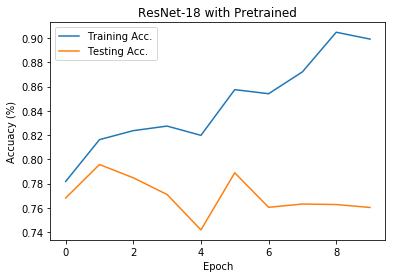

In [28]:
plt.plot(train_acc_pretrained, label="Training Acc.")
plt.plot(test_acc_pretrained, label="Testing Acc.")
plt.title("ResNet-18 with Pretrained")
plt.xlabel("Epoch")
plt.ylabel("Accuacy (%)")
plt.legend(loc="best")
plt.savefig("resnet18_pretrained.jpg")

# ResNet-18 w/o Pretrained

In [10]:
lr = 1e-3
Loss = nn.CrossEntropyLoss()
resnet_18_nopretrained = resnet18()
resnet_18_nopretrained.fc = nn.Linear(512, num_classes)
resnet_18_nopretrained.to(device)
optimizer = optim.SGD(resnet_18_nopretrained.parameters(), momentum=0.9, 
                      nesterov=True, weight_decay=5e-4, lr = lr)
epochs = 10
train_acc_18_nopretrained = []
test_acc_18_nopretrained = []
for i in range(1, epochs+1):
    train_model(resnet_18_nopretrained, train_loader, 18, True, Loss, optimizer, i) # Train model using training dataset
    acc = test_model(resnet_18_nopretrained, train_loader, "train") # Test model using training dataset
    train_acc_18_nopretrained.append(acc)
    acc = test_model(resnet_18_nopretrained, test_loader, "test") # Test model using testing dataset
    test_acc_18_nopretrained.append(acc)
    save_model(resnet_18_nopretrained, acc, 18, False, i)

Train epoch: 1	 | Loss: 0.896620 	 | Cost time: 12 m: 33 s
Test against train dataset, accuracy: 0.73, cost time: 12 m: 19 s
Test against test dataset, accuracy: 0.73, cost time: 1 m: 52 s
Save model: model/resnet_18_epoch_1_lr_0.001_pretrained_acc_0.73.pth
Train epoch: 2	 | Loss: 0.878311 	 | Cost time: 12 m: 33 s
Test against train dataset, accuracy: 0.74, cost time: 3 m: 54 s
Test against test dataset, accuracy: 0.73, cost time: 0 m: 59 s
Save model: model/resnet_18_epoch_2_lr_0.001_pretrained_acc_0.73.pth
Train epoch: 3	 | Loss: 0.894917 	 | Cost time: 9 m: 57 s
Test against train dataset, accuracy: 0.74, cost time: 4 m: 1 s
Test against test dataset, accuracy: 0.73, cost time: 1 m: 0 s
Save model: model/resnet_18_epoch_3_lr_0.001_pretrained_acc_0.73.pth
Train epoch: 4	 | Loss: 0.917305 	 | Cost time: 9 m: 57 s
Test against train dataset, accuracy: 0.74, cost time: 4 m: 0 s
Test against test dataset, accuracy: 0.73, cost time: 1 m: 0 s
Save model: model/resnet_18_epoch_4_lr_0.001_p

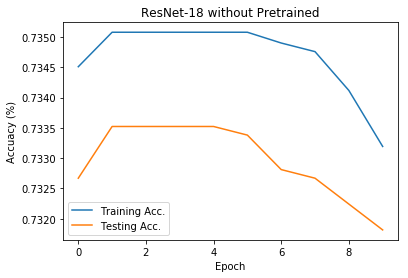

In [11]:
plt.plot(train_acc_pretrained, label="Training Acc.")
plt.plot(test_acc_pretrained, label="Testing Acc.")
plt.title("ResNet-18 without Pretrained")
plt.xlabel("Epoch")
plt.ylabel("Accuacy (%)")
plt.legend(loc="best")
plt.savefig("resnet18_nopretrained.jpg")

# ResNet-50

In [10]:
lr = 0.001
resnet50_pretrained = getMyResnet(50)
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_pretrained.parameters(), momentum=0.9, 
                      nesterov=True, weight_decay=5e-4, lr = lr)
epochs = 10
train_acc_50_pretrained = []
test_acc_50_pretrained = []
for i in range(1, epochs+1):
    train_model(resnet50_pretrained, train_loader, 50, True, Loss, optimizer, i) # Train model using training dataset
    acc = test_model(resnet50_pretrained, train_loader, "train") # Test model using training dataset
    train_acc_50_pretrained.append(acc)
    acc = test_model(resnet50_pretrained, test_loader, "test") # Test model using testing dataset
    test_acc_50_pretrained.append(acc)
    save_model(resnet50_pretrained, acc, 50, True, i)

Train epoch: 1	 | Loss: 2.173949 	 | Cost time: 25 m: 47 s


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 7.93 GiB total capacity; 6.43 GiB already allocated; 25.75 MiB free; 22.67 MiB cached)

In [ ]:
plt.plot(train_acc_50_pretrained, label="Training Acc.")
plt.plot(test_acc_50_pretrained, label="Testing Acc.")
plt.title("ResNet-50 with Pretrained")
plt.xlabel("Epoch")
plt.ylabel("Accuacy (%)")
plt.legend(loc="best")
plt.savefig("resnet50_pretrained.jpg")

In [5]:
resnet50_nopretrained = resnet50()
resnet50_nopretrained.fc = nn.Linear(2048, 5)
resnet50_nopretrained.to("cuda")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Plot Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
# Put test ground truth and predicted result into a vector, get the table and plot it